=== 模拟参数 ===
初始孔隙率: 0.800
初始阻滞系数: 10.62
干密度: 0.385 kg/L
分配系数: 20 ml/g
入流浓度: 0.005 mol/L



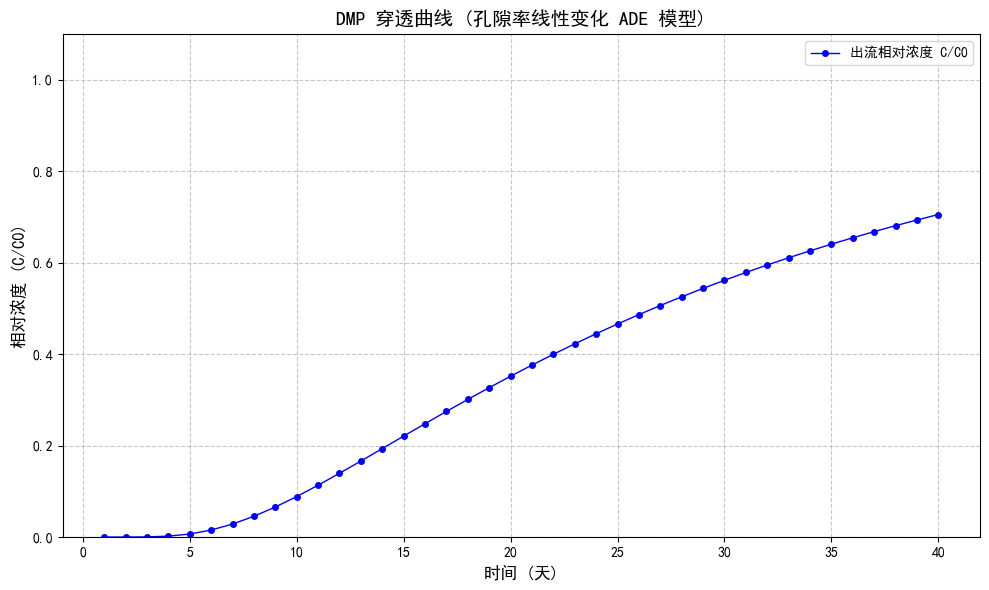

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import lil_matrix
from scipy.sparse.linalg import spsolve
import pandas as pd

# 设置中文字体
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

# ---------------- ADE ----------------
# 基本参数
kd = 20  # ml/g (分配系数)
ruo_d = 0.385  # kg/L  和阻滞系数R=1+kd/ruo_d单位统一起来，原本干密度应该是kg/m**3
D = 5e-10  # m²/s (分子扩散系数)
K = 1.6e-10  # m/s (渗透系数)
delta_H = 3  # m (入流压力)
hw = 0.75  # m (水头高度差)
L = 0.02  # m (土柱厚度)

# 孔隙率从 n0 线性增至 nf
n0 = 0.8
nf = 0.8

# 入流浓度（定值）
C_in_mol = 0.005  # mol/L

# 其它参数
t_max = 30 * 86400  # 总模拟时间 40 天（秒）
dt = 3600  # 时间步长 1 小时（秒）
n_points = 100  # 空间节点数
dx = L / (n_points - 1)

# 达西流速
v_darcy = K * (delta_H / L)

# 空间网格
x = np.linspace(0, L, n_points)

# ---------------- 初始化 ----------------
time = 0.0
C = np.zeros(n_points)  # 浓度场 (mol/L)
results = []  # 出流相对浓度
sampling_interval = 86400  # 每天采样一次（秒）
next_sample_time = sampling_interval
C0_ref = C_in_mol  # 参考入流浓度 (mol/L)

n_initial = n0
R_initial = 1 + (ruo_d / n_initial) * kd

# ---------------- 模拟主循环 ----------------
while time <= t_max:
	# 当前时间孔隙率线性插值
	n_cur = n0 + (nf - n0) * (time / t_max)

	# 计算当前阻滞系数 R = 1 + (干密度/孔隙率) * 分配系数
	R_cur = 1 + (ruo_d / n_cur) * kd

	# 计算实际速度、alpha 和 beta
	v_cur = v_darcy / n_cur
	alpha = D * dt / (R_cur * dx ** 2)
	beta = v_cur * dt / (2 * R_cur * dx)

	# 构建稀疏矩阵 A（每步更新）
	A = lil_matrix((n_points, n_points))
	# 内部节点
	for i in range(1, n_points - 1):
		A[i, i - 1] = -beta - alpha
		A[i, i] = 1 + 2 * alpha
		A[i, i + 1] = beta - alpha
	# 边界条件
	A[0, 0] = 1  # x=0 处浓度直接给定
	A[-1, -2] = 1  # Neumann 零通量
	A[-1, -1] = -1
	A = A.tocsc()

	# 构建右侧向量 b
	b = np.zeros(n_points)
	b[1:-1] = C[1:-1]
	b[0] = C_in_mol  # 使用定值入流浓度 (mol/L)
	b[-1] = 0.0

	# 求解下一时刻浓度
	C = spsolve(A, b)

	# 时间推进
	time += dt

	# 每天采样一次
	if time >= next_sample_time:
		day = time / 86400
		results.append((day, C[-1] / C0_ref))
		next_sample_time += sampling_interval

# ---------------- 提取与绘图 ----------------
days, rel_conc = zip(*results)

plt.figure(figsize=(10, 6))
plt.plot(days, rel_conc, 'bo-', markersize=4, linewidth=1, label='出流相对浓度 C/C0')
plt.xlabel('时间 (天)', fontsize=12)
plt.ylabel('相对浓度 (C/C0)', fontsize=12)
plt.title('CaCl2 5mmol@3m ADE model', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=10)
plt.ylim(0, 1.1)  # 设置y轴范围
plt.tight_layout()
# plt.savefig('CaCl2 5mmol@3m ADE model.png', dpi=300)
plt.show()



In [13]:
df = pd.DataFrame({
    '时间 (天)':         days,
    '出流相对浓度 C/C0': rel_conc,
})

excel_filename = '../5mmol@3m ADE.xlsx'
df.to_excel(excel_filename, index=False)
print(f"数据已导出至 {excel_filename}")

数据已导出至 5mmol@3m ADE.xlsx
